In [275]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re

In [277]:
#load categories and dataset
cats = pd.read_csv('final_categories_updated_6.csv' )
df = pd.read_csv('hfarm.csv', usecols = ['desc', 'n_unit', 'net_am', '_id', 'mall', 'date', 'customer'])

In [278]:
#delete transactions with non positive units/net amount
df = df[(df['n_unit']>0)&(df['net_am']>0)] 
#delete unknown
df = df[df['customer']!='Unknown'] 
#create the column unit_price
df['unit_price'] = df['net_am']/df['n_unit'] 
#drop transactions with more than 50 purchases of a single item
df = df[df['n_unit']<50] 

In [279]:
#initialise the dummies
d = {'mover' : ['hogar', 'electrodomesticos'], 
    'premium' : ['champagne', 'tienda-apple'],
    'child' : ['juguetes', 'mochilas-escolares-y-estuches', 'infantil', 'nino', 'nina'], 
     'baby' : ['bebe'],
    'pet_owner' : ['mascotas'],
    'dog_cat' : ['perros', 'gatos'], 
    'pregnant': ['embarazo-y-lactancia'],
    'dental': ['cuidado-bucal', 'boca-y-sonrisa'],
    'house_works': ['bricolaje']}

for x in d:
    cats[x] = (cats['cat1'].isin(d[x]))|(cats['cat2'].isin(d[x]))|(cats['cat3'].isin(d[x]))

In [280]:
#further selection by keyword search using regular expression
# Other premium conditions
cats.loc[np.array([re.match('.*(\s|^)ipad(\s|$).*',x) for x in cats.desc]) != None, 'premium'] = True
cats.loc[np.array([re.match('.*(\s|^)(iphone|ipho)(\s|$).*',x) for x in cats.desc]) != None, 'premium'] = True
cats.loc[np.array([re.match('.*(\s|^)adaptador apple(\s|$).*',x) for x in cats.desc]) != None, 'premium'] = True
cats.loc[np.array([re.match('.*(\s|^)jamon iberico(\s|$).*',x) for x in cats.desc]) != None, 'premium'] = True
cats.loc[np.array([re.match('.*(\s|^)led lg [45678].*',x) for x in cats.desc]) != None, 'premium'] = True
cats.loc[np.array([re.match('.*(\s|^)led sam (55|ue40|ue43|ue48|ue50|ue55).*',x) for x in cats.desc]) != None, 'premium'] = True
cats.loc[np.array([re.match('.*(\s|^)(port tos l50-c-1dw|portatil lenov z51)($|\s).*',x) for x in cats.desc]) != None, 'premium'] = True
# Other parent conditions
cats.loc[np.array([re.match('.*(\s|^)nino(\s|$).*',x) for x in cats.desc]) != None, 'child'] = True
cats.loc[(np.array([re.match('.*(\s|^)infantil(\s|$).*',x) for x in cats.desc]) != None)&(cats.cat1.isin(['libros-discos-video-papeleria-y-regalo', 'deportes-y-maletas', 'moda'])), 'child'] = True
cats.loc[(np.array([re.match('.*(\s|^)nina(\s|$).*',x) for x in cats.desc]) != None)&(cats.cat1.isin(['deportes-y-maletas', 'moda', 'especiales'])), 'child'] = True

In [281]:
#add categories for each products ot thhe dataframe 
dc = df.merge(cats, how = 'inner', on = 'desc') #

In [282]:
#create the column containing the amount spent by customers in the mover categories and the dummy for parents
dc['parent'] = (dc['child'])|(dc['baby'])

In [283]:
#extract day, week, month, hour and minute from the date columns
dc['date'] = pd.to_datetime(dc['date'])
dc['date_day'] = dc['date'].dt.dayofyear
dc['date_month'] = dc['date'].dt.month
dc['date_week'] = dc['date'].dt.isocalendar().week
dc['date_hour'] = dc['date'].dt.hour
dc['date_minute'] = dc['date'].dt.minute

#fix the first weeks because they are interpreted as last weeks of the past year 
dc.loc[dc['date_week'] == 53, 'date_week'] = dc['date_week'].min()

In [284]:
#analyse trends of quantity of interest per day
#cut initial and last observations because biased (very likely these days the supermarket was closed)
means_per_day = dc[(dc['date_day']<150)&(dc['date_day']>10)].groupby('date_day').agg({'n_unit': 'mean', 'unit_price': 'mean', 'net_am': 'sum', 
                                            '_id': 'nunique', 'customer': 'nunique'}).rename(columns = {'_id': 'tickets'})

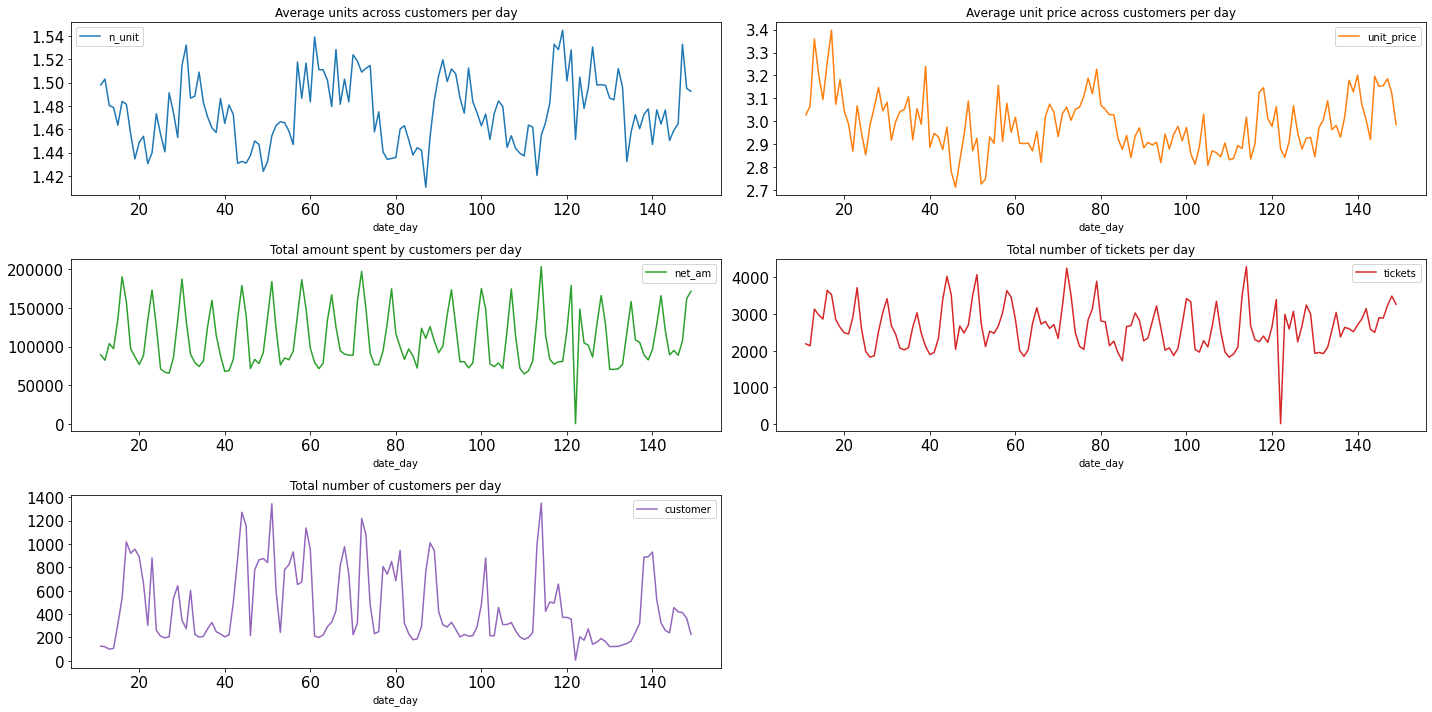

In [285]:
#notice that all the results (but tickets) are reasonable and that the weekly trend is consistent (higher amounts during weekends)
subtitles = ['Average units across customers per day', 'Average unit price across customers per day', 'Total amount spent by customers per day', 'Total number of tickets per day', 
            'Total number of customers per day']
means_per_day.plot(subplots = True, figsize = [20, 10], layout = (3,2), fontsize = 15, sharex = False,  title = subtitles)
plt.tight_layout()

From the last two plots we can observe too much difference between tickets and customers per day

In [286]:
#sum over all the transactions to get the total number of transactions related to the dummies for each customer
dummies = [x for x in d] + ['parent']
customers = dc[['customer'] + dummies].groupby(['customer']).sum()

In [303]:
#show the results: number of people selected and percentages over all the customers
dummy = customers[customers>0].count()
percentage = customers[customers>0].count()/customers.shape[0]
import dataframe_image as dfi
pd.concat([dummy,percentage], axis = 1).rename(columns = {0:'Dummies', 1:'Percentages'})

,Dummies,Percentages
mover,34073,0.527511
premium,4101,0.063491
child,20122,0.311525
baby,24828,0.384382
pet_owner,16292,0.252229
dog_cat,15153,0.234596
pregnant,1305,0.020204
dental,20269,0.313800
house_works,13440,0.208075
parent,30630,0.474207


In [306]:
#choose a threshold for movers net amount
threshold = 600

In [288]:
#focus on the amount spent by customers in the mover categories, extract the maximum for every customer
mover_net_amount = dc[dc.mover == True].groupby(['customer', 'date_day']).agg({'net_am':'sum'})
mover_net_amount_max = mover_net_amount.groupby(['customer']).net_am.max()
mover_net_amount_max.describe()

count    34073.000000
mean        27.333971
std         45.821377
min          0.010000
25%          4.000000
50%         13.700000
75%         34.570000
max       1509.770000
Name: net_am, dtype: float64

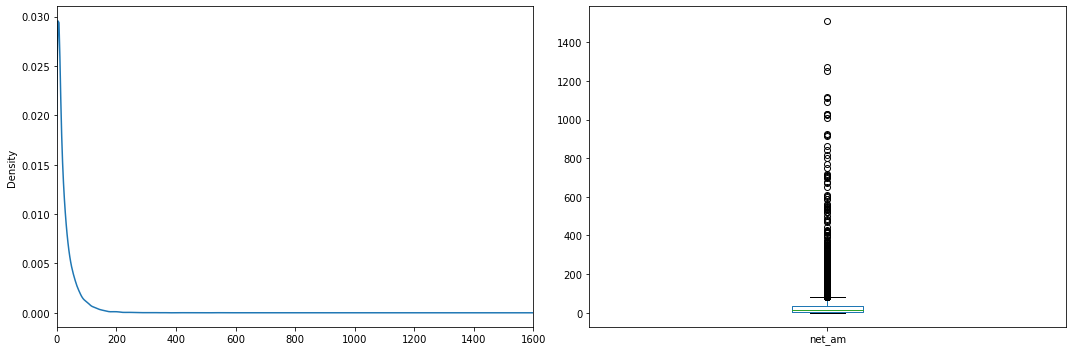

In [289]:
fig, axes = plt.subplots(1,2)
ax1, ax2 = axes
mover_net_amount_max.plot(kind = 'density', xlim = (0,1600), ax = ax1, figsize = (15,5))
mover_net_amount_max.plot(kind = 'box', ax = ax2)
plt.tight_layout()

Notice the skewness of the data

In [305]:
#select the movers
movers = mover_net_amount_max[mover_net_amount_max>threshold].index
print(f'Selected movers with threshold: {mover_net_amount_max[mover_net_amount_max>threshold].count()}')

Selected movers with threshold: 30


# Analysis of buying power

In [291]:
desc_by_customer = df.groupby('customer').desc.nunique()
good_customers = desc_by_customer.index[desc_by_customer >= 50]

In [292]:
dg = dc[dc['customer'].isin(good_customers)].copy()

In [293]:
wealth_cats = ['la-despensa', 'el-mercado', 'bebidas', 'limpieza-y-hogar', 'perfumeria-e-higiene']

In [294]:
#get average price and number of unique products per customers
agg_per_customer = dg[dg['cat1'].isin(wealth_cats)].groupby(['customer', 'cat1']).agg({'net_am': 'sum', 'n_unit': 'sum', 'desc': 'nunique'}).unstack()
agg_per_customer[['avg_price_' + cat for cat in wealth_cats]] = (agg_per_customer['net_am'][wealth_cats] / agg_per_customer['n_unit'][wealth_cats])
agg_per_customer[['unique_desc_' + cat for cat in wealth_cats]] = agg_per_customer['desc'][wealth_cats]
agg_per_customer.drop(labels=['net_am', 'n_unit', 'desc'], axis=1, inplace=True)
agg_per_customer.fillna(value=0.0, inplace=True)

In [295]:
#define the quantile function
def quantile(s):
    n = len(s)
    return (s.values[:, np.newaxis] >= s.values.T).sum(axis=1) / n

In [296]:
#define the score function based on a weighted average over the selected categories 
# of the quantile function applied to average price of the customer.
#the weights are the relative number of different products in the category over the total number of unique products
def score(df):
    n = df.shape[1] // 2
    q = df.iloc[:, :n].apply(quantile)
    w = df.values[:, n:] / df.values[:, n:].sum(axis=1, keepdims=True)
    return pd.Series((q.values * w).sum(axis=1), index=df.index, name='score')

In [297]:
#compute the score function
s = score(agg_per_customer)
s.describe()

count    27416.000000
mean         0.507003
std          0.189702
min          0.007899
25%          0.370444
50%          0.507890
75%          0.646223
max          0.979320
Name: score, dtype: float64

Text(0.5, 0.98, 'Distribution of estimated buying power score')

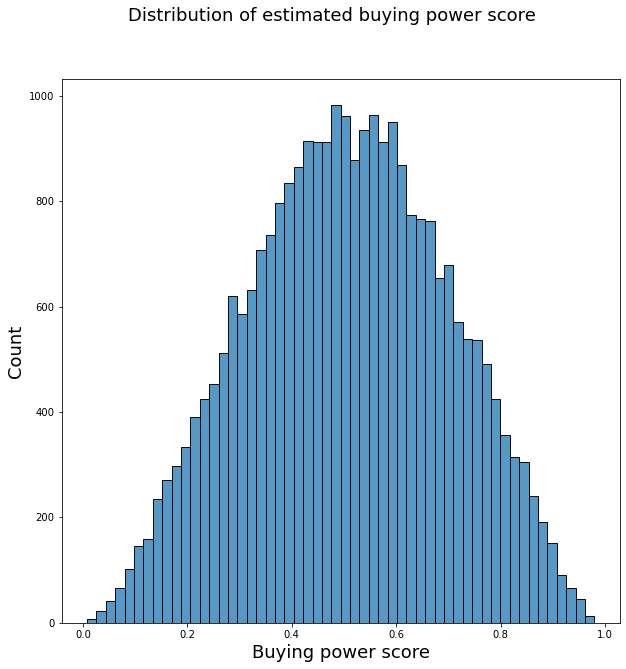

In [298]:
#plot the distribution of the scores
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(s, ax=ax)
plt.xlabel('Buying power score', fontdict={'fontsize': 18})
plt.ylabel('Count', fontdict={'fontsize': 18})
plt.suptitle('Distribution of estimated buying power score', fontsize=18)
# plt.savefig('./data/score_dist.png')

In [299]:
#merge scores and display one example of customer
targets = ['parent', 'baby', 'premium', 'pregnant', 'dental', 'house_works', 'pet_owner']
final_customers = (customers>0).astype(np.int32)[targets]
final_customers['mover'] = final_customers.index.isin(movers).astype(np.int32)
final_customers['score'] = customers.index.map(s)
#replace unknown scores with mean of our sample
final_customers['score'].fillna(s.mean(), inplace = True)

In [300]:
final_customers

,parent,baby,premium,pregnant,dental,house_works,pet_owner,mover,score
customer,,,,,,,,,
77000001548,1,0,0,0,1,1,1,0,0.526327
77000001680,1,0,0,0,1,0,1,0,0.786799
77000002166,1,1,0,0,1,0,1,0,0.282733
77000004744,1,1,0,0,1,0,1,0,0.533833
77000005496,0,0,0,0,0,0,0,0,0.507003
...,...,...,...,...,...,...,...,...,...
77099995338,0,0,0,0,0,0,0,0,0.507003
77099995489,1,1,0,0,1,1,1,0,0.742240
77099997071,0,0,0,0,0,0,0,0,0.507003
